In [1]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import gymnasium as gym

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Assignment 3
Student Name: Ji Zhou Wang
Student ID: 260518646

Student Name:
Student ID:

Student Name:
Student ID:

# Useful classes and functions

In [2]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [3]:
#OneHotEncoder for state and action function approximation representation
#Also includes Q-learning algorithm with epsilon greedy policy
class OneHotFA:
    def __init__(self, env, num_bins, actor_weights = None, critic_weights = None):
        self.env = env
        self.num_bins = num_bins
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.bins = self.get_bins()
        self.num_features = self.num_bins ** self.num_states
        self.init_actor_weights = actor_weights
        self.init_critic_weights = critic_weights
        if actor_weights is None: 
            #intialize the starting weights randomly between -0.001 and 0.001 for each feature and action
            self.actor_weights = np.random.uniform(-0.001, 0.001, (self.num_features, self.num_actions))
        else:
            self.actor_weights = actor_weights
        
        if critic_weights is None:
            #initialize critic weights
            self.critic_weights = np.random.uniform(-0.001, 0.001, self.num_features)
        else:
            self.critic_weights = critic_weights

    #print all the parameters of the class
    def print_params(self):
        print("num_bins: " + str(self.num_bins))
        print("num_states: " + str(self.num_states))
        print("num_actions: " + str(self.num_actions))
        print("bins: " + str(self.bins))
        print("num_features: " + str(self.num_features))
        print("weights: " + str(self.actor_weights))
        print("critic_weights: " + str(self.critic_weights))

    #get the bins for each state
    def get_bins(self):
        # compute the bin sizes for position and angle
        # cart_pos_binsize = (self.env.observation_space.high[0] - self.env.observation_space.low[0]) / self.num_bins
        # pole_angle_binsize = (self.env.observation_space.high[2] - self.env.observation_space.low[2]) / self.num_bins

        cart_pos_bin = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], self.num_bins+1)
        pole_angle_bin = np.linspace(self.env.observation_space.low[2], self.env.observation_space.high[2], self.num_bins+1)
        # compute the bins for cart velocity and pole angle velocity
        # calculated from sampling experiment (sd/3)
        cart_vel_bin = [-np.inf, -0.62, -0.46, -0.31, -0.15, 0.0, 0.15, 0.31, 0.46, 0.62, np.inf]
        pole_vel_bin = [-np.inf, -0.99, -0.74, -0.49, -0.24, 0.0, 0.24, 0.49, 0.74, 0.99, np.inf]

        #(sd/2)
        #cart_vel_bin = [-np.inf, -0.93, -0.70, -0.46, -0.23, 0.0, 0.23, 0.46, 0.70, 0.93, np.inf]
        #pole_vel_bin = [-np.inf, -1.49, -1.11, -0.74, -0.37, 0.0, 0.37, 0.74, 1.11, 1.49, np.inf]


        #combine all bins into one array
        bins = np.array([cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin])
        # print("bins: " + str(type(bins)) + " " + str(bins.shape))
        # print("bins: " + str(bins))
        return bins
    
    #discretize the input state into a one-hot vector of length num_features for each bin in the bins array corresponding to the state value
    def discretize_state(self, state):
        state_discrete = np.zeros(self.num_features)

        #compute the indices of the bin for each state value
        state_indices = self.get_state_indices(state)
        
        #compute the index of the overall state vector
        state_index = 0
        for i in range(self.num_states):
            state_index += (state_indices[i] - 1) * (self.num_bins ** i)
        
        #assert that the index is within the bounds of the state vector
        assert state_index < self.num_features and state_index >= 0

        #set the index of the overall state vector to 1 for the given state
        state_discrete[state_index] = 1

        return state_discrete, state_index

    #compute the indices of the bin for each state value
    def get_state_indices(self, state):
        state_indices = []
        for i in range(self.num_states):
            state_indices.append(np.digitize(state[i], self.bins[i]))
        return state_indices

    #compute the Q-value for each action with the current actor weights
    def get_Q_actions(self, state_discrete):
        Q_actions = np.dot(state_discrete, self.actor_weights)
        assert Q_actions.shape == (self.num_actions,)
        return Q_actions

    #compute the Q-value for the given state and action with the current actor weights
    def get_Q_action(self, state_discrete, action):
        Q_action = np.dot(state_discrete, self.actor_weights)[action]
        return Q_action
    
    def get_V_critic(self, state_discrete):
        V_critic = np.dot(state_discrete, self.critic_weights)
        return V_critic
    
    #update the weights for the state and action with TD(0)
    def update_weights(self, state_discrete, state_index, action, reward, alpha = 0.01):
        #compute the Q-value for the state and action
        Q = self.get_Q_action(state_discrete, action) #can use state index for more efficient computation
        #compute the TD(0)-error
        td_error = reward - Q
        #update the weights
        self.actor_weights[state_index,action] += alpha * td_error

    #update the weights using SGD with the given batch of experiences
    def update_weights_batch(self, batch, alpha = 0.01):
        #compute the Q-values for the states and actions in the batch
        Q = np.dot(batch[:,0], self.actor_weights)
        #compute the TD(0)-error
        td_error = batch[:,2] - Q
        #update the weights
        self.actor_weights += alpha * np.dot(batch[:,0].T, td_error)

    #Q-learning algorithm with epsilon-greedy policy
    def train_q_learning(self, env, episode_count = 10, alpha=0.5, gamma=0.999, epsilon=0.1, use_decay = False, epsilon_decay=0.999, seed=42):
        # Initialize a table to count the rewards for each episode
        rewards = np.zeros(episode_count)
        # Initialize a table to count the number of steps for each episode
        steps = np.zeros(episode_count)
    
        # Loop over episodes
        for ep_step in range(episode_count):
            # initialize state and action for current episode
            state, info = env.reset(seed=seed) 
            state_discrete, state_index = self.discretize_state(state)
            truncated = False
            terminated = False
            
            # Loop over time steps within the episode
            while not (terminated or truncated):

                # Choose the next action using epsilon-greedy policy
                action = self.epsilon_greedy_FA(epsilon,state_discrete)
                # Take the chosen action and observe the next state and reward
                next_state, reward, terminated, truncated, info = env.step(action)
                # Discretize the next state
                next_state_discrete, next_state_index = self.discretize_state(next_state)

                # Update the Q-value for the current state and action
                target = reward + gamma * np.max(self.get_Q_actions(next_state_discrete))
                
                # Update the weights for the current state and action
                self.update_weights(state_discrete,state_index, action, target, alpha)

                # Update the state
                state_discrete = next_state_discrete
                state_index = next_state_index
    
                # store the total discounted reward for each episode
                rewards[ep_step] += reward * (gamma ** steps[ep_step])
    
                # store the number of steps for each episode
                steps[ep_step] += 1
    
                env.render()
            
            # Decay the epsilon
            if use_decay:
                epsilon *= epsilon_decay
    
        #return the Q-table and the reward for all episodes
        return self.actor_weights, rewards, steps

    
    # Compute the policy for the given action and state (pi_theta(a,s))
    def get_prob_action(self, action, state_discrete, temperature = 1.0):
        Q_actions = self.get_Q_actions(state_discrete) #logits
        #softmax normalization
        softmax = self.softmax(Q_actions / temperature)
        #return the probability of the given action
        pi = softmax[action]
        return pi
    
    # Choose an action based on the softmax of the Q-values (pi_theta(a,s))
    def get_softmax_action(self, state_discrete, temperature=1.0):
        Q_actions = self.get_Q_actions(state_discrete)
        #softmax normalization
        softmax = self.softmax(Q_actions / temperature)         
        #choose an action based on the softmax
        action = np.random.choice(self.num_actions, p=softmax)
        return action

    # softmax function
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()


    #reinitialize the weights uniformly
    def reset_weights(self):
        if self.init_actor_weights is not None:
            self.actor_weights = self.init_actor_weights
            #intialize the starting weights randomly between -0.001 and 0.001 for each feature and action
        else:
            self.actor_weights = np.random.uniform(-0.001, 0.001, (self.num_features, self.num_actions))
        
        if self.init_critic_weights is not None:
            self.critic_weights = self.init_critic_weights
        else:
            #initialize critic weights
            self.critic_weights = np.random.uniform(-0.001, 0.001, self.num_features)

    #define epsilon-greedy policy
    def epsilon_greedy_FA(self, epsilon, state_discrete):
        if np.random.uniform() < epsilon:
            # Choose a random action with probability epsilon
            return np.random.choice(self.num_actions)
        else:
            # Choose the action with highest Q-value for the current state
            return np.argmax(self.get_Q_actions(state_discrete))
        

In [4]:
#A2C Advantage Actor-Critic agent network
#code using snippets from https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/

class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class
    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        critic_weights: The initial weights of the critic network.
        actor_weights: The initial weights of the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        critic_weights: np.ndarray,
        actor_weights: np.ndarray,
        n_envs: int,
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [nn.Linear(n_features, 1)] # estimate V(s)
        actor_layers = [nn.Linear(n_features, n_actions)] # estimate action logits (will be fed into a softmax later)
        
        # #initialize the weights of the actor and critic networks
        # if critic_weights is not None:
        #     self.critic[0].weight.data = torch.Tensor(critic_weights).to(self.device)
        # else:
        #     #uniformily initialize the weights between -0.001 and 0.001 using nn.init
        #     nn.init.uniform_(self.critic.weight, -0.001, 0.001)
        # if actor_weights is not None:
        #     self.actor[0].weight.data = torch.Tensor(actor_weights).to(self.device)
        # else:
        #     nn.init.uniform_(self.actor.weight, -0.001, 0.001)

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()


In [59]:
#Define imitation learning agent model 
#TODO look up how to do this

# Offline RL on CartPole v1 (with linear function approximation or single layer perceptron)

Gathering Expert Data
* Train the expert models before gathering
* Gather 500 behavior episodes in the task using last agent (Actor-Critic)
* Gather 500 episodes using uniformly random policy

Offline Training,
1. Simple imitation learning, use logistic regression to imitate the action observed in each state
2. Fitted Q-learning, using Q-learning targets, only with the batch of data given, K number of iterations on the episodes collected
    1. initialize Q-function randomly between -0.001 and 0.001
    2. Use two different learning rate settings 1/8 and 1/16
3. train with 100, 250, and 500 episodes data (3 data methods x 3 data size = 9 experiments)
    1. Use episodes with expert (Actor-Critic) to train the model
    2. Use episodes with uniform random to train the model
    3. Select at random, half episode from random, half from expert
4. Run greedy policy on the trained model for 100 episodes, and plot the return in a bar chart showing the average and s.d of the return for each of the 9 experiments (6 bars for each data set size) draw two horizontal lines at the average return of the offline RL methods (the same number of episode data). 3 graphs in total.

Write a small report that describes your experiment, including how you decided to stop the training,
the results, and the conclusions you draw from this experimentation. Comment on whether the
algorithms are matching and/or exceeding the performance of the policies used to generate the
data. Comment also on the impact of the data set size and data quality on the results.



In [6]:
# set hyperparameters to gather expert data 
experiment_count = 1
episode_count = 2000 #number of episodes to gather expert data


# set hyperparameters for linear function approximator
bins = 10 #number of bins for discretization as features for linear function approximator
num_states = 4 #number of states
num_features = bins**num_states #number of features for linear function approximator
num_actions = 2 #number of actions


In [7]:
#define initial weights for linear function approximator
critic_weights = np.random.uniform(-0.001, 0.001, num_features)
#actor_weights = np.random.uniform(-0.001, 0.001, (num_features, num_actions)) #different action weights
actor_weights = np.stack((critic_weights, critic_weights), axis=1) #same action weights
actor_weights_ac = np.random.uniform(-0.001, 0.001, (num_actions, num_features))


## A2C data collection
for discrete, could use index to store state space, save memory


In [12]:
# environment hyperparams
n_envs = 1
n_steps_per_update = 500  # number of steps before updating the network, max number of steps
randomize_domain = False

# agent hyperparams
lam = 0.95  # hyperparameter for GAE, TD(lambda) lam = 1 is equivalent to MC, lam = 0 is equivalent to TD(0)
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
alpha = 1/16 #learning rates actor 
beta = 1/4 #learning rates critic (betas are 4x larger than alphas)
gamma = 0.99  # discount factor
device = "cpu"
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

#initialize arrays to store the average rewards for each episode, each experiment, each alphas for Actor-Critic
critic_losses_ac_nn = np.zeros((experiment_count, episode_count))
actor_losses_ac_nn = np.zeros((experiment_count, episode_count))
entropies_ac_nn = np.zeros((experiment_count, episode_count))
rewards_ac_nn = np.zeros((experiment_count, episode_count))


### Train expert agent

In [9]:
#training the expert agent
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

#define an array to store the state, action, next_state, reward for each episode for each experiment
expert_data_ac_temp = []
#gather data and loop over all experiments for A2C agent
for exp in range(experiment_count):
    print("Experiment: " + str(exp) + " alpha: " + str(alpha) + " beta: " + str(beta))
    
    #initialize the A2C agent
    agent = A2C(num_features, num_actions, device = device, critic_lr=beta, actor_lr=alpha, critic_weights=critic_weights, actor_weights=actor_weights_ac, n_envs=n_envs)
    
    agent.critic[0].weight.data = torch.Tensor(critic_weights).to(device)
    agent.actor[0].weight.data = torch.Tensor(actor_weights_ac).to(device)
    
    #envs = gym.vector.make('CartPole-v1', num_envs=n_envs, render_mode='rgb_array', max_episode_steps=600)
    envs = gym.vector.make('CartPole-v1', num_envs=n_envs)
    # create a wrapper environment to save episode returns and episode lengths
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * episode_count)
    

    critic_losses = []
    actor_losses = []
    entropies = []
    episode_data = []
    rewards_each_ep = np.zeros(episode_count)
    
    # use tqdm to get a progress bar for training
    for ep in tqdm(range(episode_count)):
    
        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        #initialize the discrete state space
        state_discrete = np.zeros((n_envs, num_features))
        next_state_discrete = np.zeros((n_envs, num_features))

        # at the start of training reset all envs to get an initial state
        #if ep == 0:
        states, info = envs_wrapper.reset(seed=seed)
        #discretize the state space for each n_envs
        for i in range(n_envs):
            state_discrete[i], _ = oh.discretize_state(states[i])
        truncated = False
        terminated = False
        step = 0
        episode_memory = []
        # play n steps in our parallel environments to collect data
        #for step in range(n_steps_per_update):
        while not (terminated or truncated):
            # select an action A_{t} using S_{t} as input for the agent

            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                torch.from_numpy(state_discrete).float().unsqueeze(0).to(device=device)
            )
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, rewards, terminated, truncated, infos = envs_wrapper.step(
                actions.numpy()[0]
            )
            #store the total discounted rewards for each episode
            rewards_each_ep[ep] += rewards * (gamma ** step)
    
            #discretize the state space for each n_envs
            for i in range(n_envs):
                next_state_discrete[i], _ = oh.discretize_state(states[i])
            

            episode_memory.append((state_discrete.squeeze(), np.array(actions.squeeze().item()), next_state_discrete.squeeze(), rewards.squeeze()))

            state_discrete = next_state_discrete

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs
    
            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])
            step += 1


        episode_data.append(np.array(episode_memory))

        
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )
    
        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)
    
        # log the losses and entropy
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())

    #save critic losses for each experiment
    critic_losses_ac_nn[exp, :] = critic_losses
    #save actor losses for each experiment
    actor_losses_ac_nn[exp, :] = actor_losses
    #save entropy for each experiment
    entropies_ac_nn[exp, :] = entropies

    #save the rewards for each episode
    rewards_ac_nn[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_ac_temp.append(np.array(episode_data))

    #close the environment
    envs_wrapper.close()

expert_data_ac_temp = np.array(expert_data_ac_temp).squeeze() #with one experiment use squeeze


Experiment: 0 alpha: 0.0625 beta: 0.25


  2%|▏         | 43/2000 [00:07<05:21,  6.08it/s]


KeyboardInterrupt: 

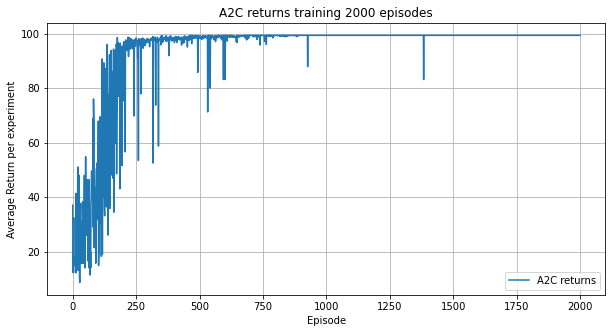

In [60]:
#plot and label the curve with mean over all experiments for each episode for actor and critic nn
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_ac_nn[:,:], axis=0), label='A2C returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('A2C returns training 2000 episodes')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#print the shape of the expert data for actor critic
print(expert_data_ac_temp.shape) # number of episodes in first experiment
print(expert_data_ac_temp.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac_temp[0].shape) # number of steps in first episode
print(expert_data_ac_temp[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_temp[0][0]) # first step values S_t, A_t, S_t+1, R_t

### Gathering 500 episodes of expert data A2C

In [13]:
# set hyperparameters to gather expert data 
experiment_count = 1
episode_count = 500 #number of episodes to gather expert data

# set hyperparameters for training
gamma = 0.99 #discount factor


# set hyperparameters for linear function approximator
bins = 10 #number of bins for discretization as features for linear function approximator
num_features = bins**num_states #number of features for linear function approximator
num_actions = 2 #number of actions

#initialize arrays to store the average rewards for each episode, each experiment, each alphas for Actor-Critic
critic_losses_ac_nn = np.zeros((experiment_count, episode_count))
actor_losses_ac_nn = np.zeros((experiment_count, episode_count))
entropies_ac_nn = np.zeros((experiment_count, episode_count))
rewards_ac_nn = np.zeros((experiment_count, episode_count))

In [14]:
#save A2C agent model weights using torch save
# torch.save(agent.critic[0].weight.data, 'critic_weights_ac_nn.pt')
# torch.save(agent.actor[0].weight.data, 'actor_weights_ac_nn.pt')


#load agent model using torch load
agent = A2C(num_features, num_actions, device = device, critic_lr=beta, actor_lr=alpha, critic_weights=critic_weights, actor_weights=actor_weights_ac, n_envs=n_envs)

#print agent weights
print(agent.critic[0].weight.data)
print(agent.actor[0].weight.data)

#load agent model weights using torch load
agent.critic[0].weight.data = torch.load('critic_weights_ac_nn.pt')
agent.actor[0].weight.data = torch.load('actor_weights_ac_nn.pt')

#print agent weights
print(agent.critic[0].weight.data)
print(agent.actor[0].weight.data)

tensor([[ 0.0094,  0.0076,  0.0002,  ..., -0.0002,  0.0032, -0.0048]])
tensor([[ 0.0058,  0.0050,  0.0057,  ..., -0.0030, -0.0087,  0.0001],
        [ 0.0007, -0.0069, -0.0087,  ..., -0.0094,  0.0016, -0.0044]])
tensor([-0.0003,  0.0009,  0.0005,  ...,  0.0009, -0.0002, -0.0006])
tensor([[-0.0003, -0.0003, -0.0006,  ..., -0.0004, -0.0001, -0.0007],
        [ 0.0005, -0.0006, -0.0003,  ..., -0.0010, -0.0002, -0.0005]])


In [15]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

#define an array to store the state, action, next_state, reward for each episode for each experiment
expert_data_ac = []
expert_data_ac_discrete = []

#gather data and loop over all experiments for A2C agent
for exp in range(experiment_count):
    print("Experiment: " + str(exp) + " alpha: " + str(alpha) + " beta: " + str(beta))
    
    #using the previous trained A2C agent
    
    #envs = gym.vector.make('CartPole-v1', num_envs=n_envs, render_mode='rgb_array', max_episode_steps=600)
    envs = gym.vector.make('CartPole-v1', num_envs=n_envs)
    #create a wrapper environment to save episode returns and episode lengths
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * episode_count)
    
    critic_losses = []
    actor_losses = []
    entropies = []
    episode_data = []
    episode_data_discrete = []

    rewards_each_ep = np.zeros(episode_count)
    
    # use tqdm to get a progress bar for training
    for ep in tqdm(range(episode_count)):
    
        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        #initialize the discrete state space
        state_discrete = np.zeros((n_envs, num_features))
        next_state_discrete = np.zeros((n_envs, num_features))

        # at the start of training reset all envs to get an initial state
        #if ep == 0:
        states, info = envs_wrapper.reset(seed=seed)
        #discretize the state space for each n_envs
        for i in range(n_envs):
            state_discrete[i], _ = oh.discretize_state(states[i])
        truncated = False
        terminated = False
        step = 0
        episode_memory = []
        episode_memory_discrete = []
        # play n steps in our parallel environments to collect data
        #for step in range(n_steps_per_update):
        while not (terminated or truncated):
            # select an action A_{t} using S_{t} as input for the agent

            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                torch.from_numpy(state_discrete).float().unsqueeze(0).to(device=device)
            )
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            next_states, rewards, terminated, truncated, infos = envs_wrapper.step(
                actions.numpy()[0]
            )
            #store the total discounted rewards for each episode
            rewards_each_ep[ep] += rewards * (gamma ** step)
    
            #discretize the state space for each n_envs
            for i in range(n_envs):
                next_state_discrete[i], _ = oh.discretize_state(next_states[i])
            

            episode_memory.append((states[0].squeeze(), np.array(actions.squeeze().item()), next_states[0].squeeze(), rewards.squeeze()))
            episode_memory_discrete.append((state_discrete[0].squeeze(), np.array(actions.squeeze().item()), next_state_discrete[0].squeeze(), rewards.squeeze()))

            state_discrete = next_state_discrete

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs
    
            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])
            step += 1

        episode_data.append(np.array(episode_memory))
        episode_data_discrete.append(np.array(episode_memory_discrete))
        
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )
    
        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)
    
        # log the losses and entropy
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())

    #save critic losses for each experiment
    critic_losses_ac_nn[exp, :] = critic_losses
    #save actor losses for each experiment
    actor_losses_ac_nn[exp, :] = actor_losses
    #save entropy for each experiment
    entropies_ac_nn[exp, :] = entropies

    #save the rewards for each episode
    rewards_ac_nn[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_ac.append(np.array(episode_data))
    expert_data_ac_discrete.append(np.array(episode_data_discrete))

    #close the environment
    envs_wrapper.close()

expert_data_ac = np.array(expert_data_ac).squeeze() #with one experiment use squeeze
expert_data_ac_discrete = np.array(expert_data_ac_discrete).squeeze() #with one experiment use squeeze



Experiment: 0 alpha: 0.0625 beta: 0.25


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 500/500 [13:16<00:00,  1.59s/it]
c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

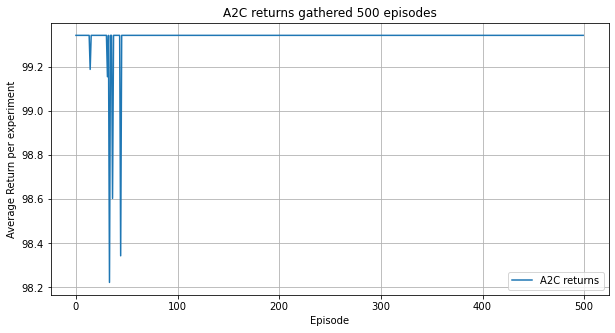

In [16]:
#plot and label the curve with mean over all experiments for each episode for actor and critic nn
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_ac_nn[:,:], axis=0), label='A2C returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('A2C returns gathered 500 episodes')
plt.legend()
plt.grid()
plt.show()

In [17]:
#print the shape of the expert data for actor critic
#shape shows every episode ended up with optimal reward eg. 500 steps
print(expert_data_ac.shape) # number of episodes in first experiment
print(expert_data_ac.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac[0].shape) # number of steps in first episode
print(expert_data_ac[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac[0][0]) # first step values S_t, A_t, S_t+1, R_t

(500,)
(500,)
(500, 4)
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(1)
 array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)
 array(1.)]


In [18]:
#print the shape of the expert data discrete for actor critic
#shape shows every episode ended up with optimal reward eg. 500 steps
print(expert_data_ac_discrete.shape) # number of episodes in first experiment
print(expert_data_ac_discrete.squeeze().shape) # number of episodes in first experiment
print(expert_data_ac_discrete[0].shape) # number of steps in first episode
print(expert_data_ac_discrete[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_discrete[0][0]) # first step values S_t, A_t, S_t+1, R_t


(500,)
(500,)
(500, 4)
(4,)
[array([0., 0., 0., ..., 0., 0., 0.]) array(1)
 array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]


### Gather 500 episodes using Uniform random policy

In [19]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)
env.close()

expert_data_uf = []
expert_data_uf_discrete = []

#gather data and loop over all experiments for uniformly random policy
rewards_uf = np.zeros((experiment_count, episode_count))

for exp in range(experiment_count):
    print("Uniform random policy Experiment: " + str(exp))
    #initialize the environment
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Initialize a table to count the rewards for each episode
    rewards_each_ep = np.zeros(episode_count)
    episode_data = []
    episode_data_discrete = []

    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in tqdm(range(episode_count)):
        # initialize state and action for current episode
        state, info = env.reset(seed=seed) 
        state_discrete, _ = oh.discretize_state(state)

        truncated = False
        terminated = False
        
        episode_memory = []
        episode_memory_discrete = []
        
        # Loop over time steps within the episode
        while not (terminated or truncated):
            # Choose the next action using uniform random policy
            action = uniform_random(num_actions)
            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_discrete, _ = oh.discretize_state(next_state)

            # store the total reward for each episode
            rewards_each_ep[ep] += reward * (gamma ** step)

            episode_memory.append((state, np.asarray(action), next_state, np.asarray(reward)))
            episode_memory_discrete.append((state_discrete, np.asarray(action), next_state_discrete, np.asarray(reward)))          

            # store the number of steps for each episode
            steps[ep] += 1
            env.render()

        episode_data.append(np.array(episode_memory))
        episode_data_discrete.append(np.array(episode_memory_discrete))

    #save the rewards for each episode
    rewards_uf[exp, :] = rewards_each_ep

    #save the episode data
    expert_data_uf.append(np.array(episode_data))
    expert_data_uf_discrete.append(np.array(episode_data_discrete))

    #close the environment
    env.close()

expert_data_uf = np.array(expert_data_uf).squeeze() #with one experiment use squeeze
expert_data_uf_discrete = np.array(expert_data_uf_discrete).squeeze() #with one experiment use squeeze

Uniform random policy Experiment: 0


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 500/500 [00:40<00:00, 12.44it/s]
c:\Users\ccarc\Anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

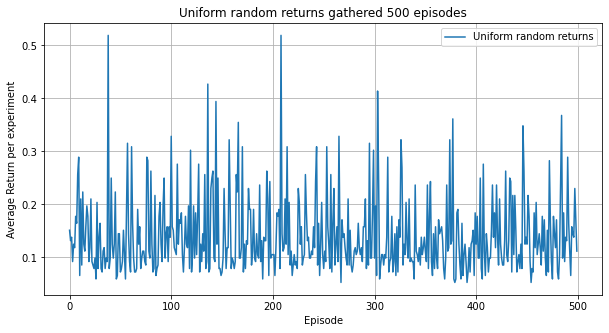

In [20]:
#plot and label the curve with mean over all experiments for each episode for uniformly random policy
#all in one plot
plt.figure(figsize=(10, 5))
plt.plot(np.mean(rewards_uf[:,:], axis=0), label='Uniform random returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('Uniform random returns gathered 500 episodes')
plt.legend()
plt.grid()
plt.show()

In [21]:
#print the shape of the expert data for uniformly random policy
print(expert_data_uf.shape) # number of episodes
print(expert_data_uf[0].shape) # number of steps in first episode
print(expert_data_uf[0].shape[0]) # number of steps in first episode
print(expert_data_uf[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_uf[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_uf[0][0][0]) # first step values S_t
print(expert_data_uf[0][0][1]) # first step values A_t


(500,)
(23, 4)
23
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(0)
 array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32)
 array(1.)]
[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
0


In [22]:
#print the shape of the expert data discrete for uniformly random policy
print(expert_data_uf_discrete.shape) # number of episodes
print(expert_data_uf_discrete[0].shape) # number of steps in first episode
print(expert_data_uf_discrete[0].shape[0]) # number of steps in first episode
print(expert_data_uf_discrete[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_uf_discrete[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_uf_discrete[0][0][0]) # first step values S_t
print(expert_data_uf_discrete[0][0][1]) # first step values A_t


(500,)
(23, 4)
23
(4,)
[array([0., 0., 0., ..., 0., 0., 0.]) array(0)
 array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
[0. 0. 0. ... 0. 0. 0.]
0


In [23]:
#randomly select half of the indices from expert_data_ac and half of the indices from expert_data_uf episodes
#from a list of indices length of episodes
indices = list(range(episode_count))
random.shuffle(indices)
print(indices)

#select half of the indices from expert_data_ac and half of the indices from expert_data_uf episodes
#combine them in a new array called expert_data_ac_uf
expert_data_ac_uf = np.empty((episode_count), dtype=object)
for i in range(episode_count):
    if i < episode_count/2:
        expert_data_ac_uf[indices[i]] = expert_data_ac[indices[i]]
    else:
        expert_data_ac_uf[indices[i]] = expert_data_uf[indices[i]]

#same for discrete
expert_data_ac_uf_discrete = np.empty((episode_count), dtype=object)
for i in range(episode_count):
    if i < episode_count/2:
        expert_data_ac_uf_discrete[indices[i]] = expert_data_ac_discrete[indices[i]]
    else:
        expert_data_ac_uf_discrete[indices[i]] = expert_data_uf_discrete[indices[i]]

expert_data_ac_uf = np.array(expert_data_ac_uf).squeeze() #with one experiment use squeeze
expert_data_ac_uf_discrete = np.array(expert_data_ac_uf_discrete).squeeze() #with one experiment use squeeze

[164, 383, 45, 156, 53, 72, 315, 209, 74, 333, 403, 415, 92, 215, 479, 59, 368, 163, 210, 251, 443, 320, 289, 389, 7, 462, 249, 228, 245, 211, 129, 162, 223, 41, 278, 21, 434, 68, 227, 151, 369, 217, 154, 177, 397, 139, 141, 326, 175, 170, 88, 96, 439, 303, 50, 199, 297, 131, 120, 358, 180, 370, 37, 160, 4, 93, 304, 188, 374, 453, 94, 468, 292, 340, 407, 408, 187, 334, 213, 127, 11, 6, 442, 246, 396, 425, 345, 89, 426, 26, 77, 184, 262, 207, 182, 95, 100, 419, 394, 155, 230, 362, 237, 353, 85, 323, 171, 393, 153, 313, 38, 392, 69, 106, 348, 489, 428, 158, 31, 244, 8, 267, 485, 233, 261, 401, 291, 198, 132, 324, 322, 2, 18, 488, 263, 76, 253, 314, 351, 471, 143, 449, 66, 179, 133, 144, 406, 280, 269, 466, 208, 145, 432, 277, 341, 465, 317, 17, 448, 20, 130, 238, 296, 286, 336, 300, 149, 203, 387, 398, 190, 201, 418, 14, 55, 75, 284, 39, 391, 460, 257, 178, 212, 472, 420, 67, 99, 476, 97, 196, 339, 288, 318, 457, 124, 242, 42, 60, 192, 422, 266, 254, 384, 497, 226, 495, 113, 19, 218, 118

In [24]:
#print the shape of the expert data for actor critic and uniformly random policy
print(expert_data_ac_uf.shape) # number of episodes
print(expert_data_ac_uf[216].shape) # (number of steps in first episode, num_states)
print(expert_data_ac_uf[0].shape[0]) # number of steps in first episode
print(expert_data_ac_uf[0][0].shape) # shape of first step S_t, A_t, S_t+1, R_t
print(expert_data_ac_uf[0][0]) # first step values S_t, A_t, S_t+1, R_t
print(expert_data_ac_uf[0][0][0].shape) # first step values S_t
print(expert_data_ac_uf[0][0][1]) # first step values A_t



(500,)
(31, 4)
23
(4,)
[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)
 array(0)
 array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32)
 array(1.)]
(4,)
0


In [25]:
#stack all data into one array
expert_data_all = np.stack((expert_data_ac, expert_data_uf,expert_data_ac_uf), axis=0)
expert_data_all_discrete = np.stack((expert_data_ac_discrete, expert_data_uf_discrete,expert_data_ac_uf_discrete), axis=0)

#save the expert data #very large!!!
# np.save('expert_data_all.npy', expert_data_all)
# np.save('expert_data_all_discrete.npy', expert_data_all_discrete)


In [26]:
#print the save for continuous
# print(expert_data_ac)
# print(expert_data_all[0].shape)
# print(len(expert_data_all))

#print the save for discrete
print(expert_data_uf_discrete[0])
print(expert_data_ac_discrete[0])
print(expert_data_all_discrete[0][0].shape)
print(len(expert_data_all_discrete))


[[array([0., 0., 0., ..., 0., 0., 0.]) array(0)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(0)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(0)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(0)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0., ..., 0., 0., 0.]) array(1)
  array([0., 0., 0., ..., 0., 0., 0.]) array(1.)]
 [array([0., 0., 0.,

## Offline RL
Using expert data
A2C: expert_data_ac
Uniform random: expert_data_uf

In [27]:
# set hyperparameters for training
episode_cs = [100, 250, 500] # number of episode sizes to select from in each experiment
alphas = [1/8, 1/16] # learning rates
gamma = 0.99 # discount factor

### Simple imitation learning

In [ ]:
#Offline training using expert data on a policy network model (supervised)
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oh = OneHotFA(env, bins)

# Initialize a table to count the rewards for each episode
rewards = np.zeros(episode_count)
# Initialize a table to count the number of steps for each episode
steps = np.zeros(episode_count)

# Loop over episodes
for ep_step in tqdm(range(episode_count)):
    # get first state and action for current episode
    state_discrete = expert_data_ac[0][0][0]
    first_action = expert_data_ac[0][0][1]
    # state_discrete, _ = oh.discretize_state(state) #already discretized
    truncated = False
    terminated = False
    episode_memory = []

    # Loop over time steps within the episode
    while not (terminated or truncated):
        # Choose the next action using policy network #TODO use imitation learning (supervised learning)
        action = oh.get_softmax_action(state_discrete, temperature = 0.01)

        # Take the chosen action and observe the next state and reward
        # next_state, reward, terminated, truncated, info = env.step(action)

        # Get the previous action, next state and reward from expert data
        expert_previous_action = expert_data_ac[0][steps[ep_step]][1]
        next_state_discrete = expert_data_ac[0][steps[ep_step]][2]
        reward = expert_data_ac[0][steps[ep_step]][3]

        #terminated set to true if the step size is equal to
        if steps[ep_step] == expert_data_ac[0].shape[0] - 1:
            terminated = True

        # Discretize the next state
        #next_state_discrete, next_state_index = oh.discretize_state(next_state)

        episode_memory.append((state_discrete, action, reward, next_state_discrete))

        # Update the state TODO need?
        state_discrete = next_state_discrete

        # store the total reward for each episode
        rewards[ep_step] += rewards * (gamma ** steps[ep_step])
        # store the number of steps for each episode
        steps[ep_step] += 1

        env.render()



    #TODO Update using imitation learning after each episode use
    for t in range(len(episode_memory)):
        state_discrete, action, reward, next_state_discrete = episode_memory[t]
        state_index = np.argmax(state_discrete)
        next_state_index = np.argmax(next_state_discrete)

        #TODO

env.close()


In [ ]:
#print and plot the average rewards (return) with its standard deviation for all episodes
print("Average reward: ", np.mean(rewards))
print("Standard deviation: ", np.std(rewards))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


#### Online greedy test run

In [ ]:
#online greedy testing parameters
episode_count = 100
rewards_il = np.zeros((experiment_count, episode_count))


#A2C agent #TODO use imitation learning agent weights
QFunction = agent.actor[0].weight.data



#initialize the environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to discretize the state space
oha = OneHotFA(env, bins)

# Initialize a table to count the rewards for each episode
rewards_each_ep = np.zeros(episode_count)
episode_data = []
expert_data_il = []

# Initialize a table to count the number of steps for each episode
steps = np.zeros(episode_count)

# Loop over episodes
for ep in range(episode_count):
    # initialize state and action for current episode
    state, info = env.reset(seed=seed) 
    state_discrete, state_index = ofa.discretize_state(state)
    truncated = False
    terminated = False
    
    episode_memory = []
    
    # Loop over time steps within the episode
    while not (terminated or truncated):

        # Choose the next action using greedy policy
        action = epsilon_greedy(QFunction, state_discrete, num_actions=num_actions, epsilon=0.0)
        # Take the chosen action and observe the next state and reward
        next_state, reward, terminated, truncated, info = env.step(action)
        # Discretize the next state
        next_state_discrete, next_state_index = ofa.discretize_state(next_state)

        episode_memory.append((state_discrete, np.asarray(action), next_state_discrete, np.asarray(reward)))

        # Update the state
        state_discrete = next_state_discrete

        # store the total reward for each episode
        rewards_each_ep[ep] += reward * (gamma ** step)

        # store the number of steps for each episode
        steps[ep] += 1

        env.render()

    episode_data.append(np.array(episode_memory))

#save the rewards for each episode
rewards_il[exp, :] = rewards_each_ep

#save the episode data
expert_data_il.append(np.array(episode_data))

#close the environment
env.close()

In [ ]:
#plot the average rewards (return) with its standard deviation for all episodes
print("Average reward: ", np.mean(rewards_il))
print("Standard deviation: ", np.std(rewards_il))
plt.plot(rewards_il)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

### Fitted Q-learning with logistic regression (SKLearn) (only runs on a single data set)

In [193]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Define the hyperparameters
learning_rate = 0.001
tolerance = 1e-5
selected_data = 0
batch_size = int(episode_cs[selected_data]/2)
gamma = 0.99
K_iterations = 10
print("Max iterations: ", K_iterations)

# Initialize the logistic regression model
q_logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

# Initialize the q_logreg model uniformly at random between -0.001 and 0.001
q_logreg.coef_ = np.random.uniform(-0.001, 0.001, size=(num_actions, num_features))
q_logreg.intercept_ = np.random.uniform(-0.001, 0.001, size=(num_actions))


c_episode = 0
loss_values = np.zeros(K_iterations)
prev_loss = np.inf

for t in tqdm(range(K_iterations)):
    if c_episode >= episode_cs[0]:
        c_episode = 0

    batch_indices = np.arange(c_episode, min(c_episode+batch_size, expert_data_ac_uf.shape[0]))

    expert_batch = expert_data_ac_discrete[batch_indices]

    for expert_data in expert_batch:

        states = np.stack([a for a in expert_data[:, 0]]).astype(np.float32)
        actions = np.stack([a for a in expert_data[:, 1]]).astype(np.int64)
        next_inputs = np.stack([a for a in expert_data[:, 2]]).astype(np.float32)
        rewards = np.stack([a for a in expert_data[:, 3]]).astype(np.float32)
        step_size = expert_data.shape[0]

        with np.errstate(all='ignore'):
            next_q_values = q_logreg.predict_proba(next_inputs)
            target_qsa = rewards + gamma * np.max(next_q_values, axis=1)

        q_logreg.fit(states, actions, sample_weight=target_qsa)

        #loss = q_logreg.score(states, actions)
        # Calculate the mean squared error as the loss
        predicted_q_values = q_logreg.predict_proba(states)
        predicted_qsa = predicted_q_values[np.arange(step_size), actions]
        loss = mean_squared_error(target_qsa, predicted_qsa)

        if abs(loss - prev_loss) < tolerance:
            print('Convergence reached after {} episode'.format(c_episode))
            print('Loss difference: ', abs(loss - prev_loss))
            break

        prev_loss = loss

    c_episode += batch_size

    loss_values[t] = loss
    print('Loss: ', loss)


Max iterations:  10
Convergence reached after 0 epochs
Loss difference:  2.3395226667055624e-07
Loss:  0.9901746608853138
Convergence reached after 1 epochs
Loss difference:  3.861619555345364e-06
Loss:  0.9901710332180251
Convergence reached after 2 epochs
Loss difference:  2.339527025441157e-07
Loss:  0.9901746608841461
Convergence reached after 3 epochs
Loss difference:  3.8616189588225325e-06
Loss:  0.9901710332178898
Convergence reached after 4 epochs
Loss difference:  2.3395136516946025e-07
Loss:  0.9901746608849484
Convergence reached after 5 epochs
Loss difference:  3.861617972278353e-06
Loss:  0.9901710332183413
Convergence reached after 6 epochs
Loss difference:  2.3395257842118156e-07
Loss:  0.9901746608849638
Convergence reached after 7 epochs
Loss difference:  3.861618917411214e-06
Loss:  0.9901710332186248
Convergence reached after 8 epochs
Loss difference:  2.339527025441157e-07
Loss:  0.9901746608841461
Convergence reached after 9 epochs
Loss difference:  3.861618958822

In [201]:
#online greedy testing parameters
episode_count = 100
q_agent = q_logreg

#Offline training using expert data on a policy network model (supervised)
env = gym.make('CartPole-v1', render_mode='rgb_array')
#use encoder to for Fitted Q-learning and discretize the state space
oh = OneHotFA(env, bins)

# Initialize a table to count the rewards for each episode
rewards = np.zeros(episode_count)
# Initialize a table to count the number of steps for each episode
steps = np.zeros(episode_count)

# Loop over episodes
for ep in range(episode_count):
    # initialize state and action for current episode
    state, info = env.reset() 
    state_discrete, state_index = oh.discretize_state(state)
    truncated = False
    terminated = False

    # Loop over time steps within the episode
    while not (terminated or truncated):

        # Choose the next action using greedy policy
        action = epsilon_greedy(q_agent, state_discrete, num_actions=num_actions, epsilon=0.0)
        # Take the chosen action and observe the next state and reward
        next_state, reward, terminated, truncated, info = env.step(action)
        # Discretize the next state
        next_state_discrete, next_state_index = oh.discretize_state(next_state)

        # Update the state
        state_discrete = next_state_discrete

        # store the total reward for each episode
        rewards[ep] += reward * (gamma ** steps[ep])

        # store the number of steps for each episode
        steps[ep] += 1

        env.render()


#save the rewards for each episode
rewards_fq_ac = rewards

#close the environment
env.close()

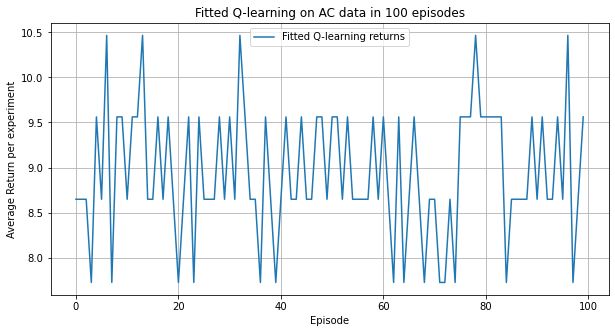

In [202]:
#plot and label the curve with mean over all experiments for each episode for greedy policy for Fitted Q-learning on AC data
plt.figure(figsize=(10, 5))
plt.plot(rewards_fq_ac, label='Fitted Q-learning returns')
plt.xlabel('Episode')
plt.ylabel('Average Return per experiment')
plt.title('Fitted Q-learning on AC data in 100 episodes')
plt.legend()
plt.grid()
plt.show()

### Fitted Q-learning with linear FA Discrete Binned States (PyTorch) (runs through all 9 data sets)

In [40]:
#define function approximator
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class Q_Net(nn.Module):
    def __init__(self, state_size, action_size):
        super(Q_Net, self).__init__()
        self.linear = nn.Linear(state_size, action_size)
        nn.init.uniform_(self.linear.weight, a=-0.001, b=0.001)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)
        #return out

# Define the hyperparameters
learning_rate = 0.001
tolerance = 1e-5
gamma = 0.99


In [42]:
#batch training for all agent in fitted Q-learning

#initialize an array to store all 9 experiment agents
q_nets = np.zeros(9, dtype=object)
agent_index = 0

#loop through the selected data lengths
for selected_data in range(len(episode_cs)):
    #loop through the selected methods
    for selected_method in range(len(expert_data_all_discrete)):

        q_net = Q_Net(num_features, num_actions)
        #criterion = nn.MSELoss()
        criterion = nn.BCELoss()
        optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

        s = 1 #batch split factor
        batch_size = int(episode_cs[selected_data] / s)
        k = 5
        K_iterations = int(episode_cs[selected_data]/batch_size) * k
        #print("Max iterations: ", K_iterations)

        # Loop over K_iterations
        c_episode = 0

        #array to store loss values
        loss_values = np.zeros(K_iterations)

        for t in tqdm(range(K_iterations)):
            #check if c_episode is greater than cs_episode, reset c_episode to 0
            if c_episode >= episode_cs[0]:
                c_episode = 0

            # Loop over all episodes in batch and store their ouputs
            batch_indices = np.arange(c_episode, min(c_episode+batch_size, expert_data_ac_uf.shape[0]))
            #print(batch_indices)

            #run until convergence
            prev_loss = 0

            # Loop over episodes in selected batch indices
            expert_batch = expert_data_all_discrete[selected_method][batch_indices]
            
            # Loop over time steps within the episode (load the batches of data)
            for expert_data in expert_batch:
                
                # print(expert_data.shape)
                # print(expert_data[:, 0].shape)
                # print(expert_data[:, 0])
                
                states = torch.stack([torch.from_numpy(a) for a in expert_data[:, 0]]).float()
                actions = torch.stack([torch.from_numpy(a) for a in expert_data[:, 1]]).long()
                next_inputs = torch.stack([torch.from_numpy(a) for a in expert_data[:, 2]]).float()
                rewards = torch.stack([torch.from_numpy(a) for a in expert_data[:, 3]]).float()
                step_size = expert_data.shape[0]


                # store the target Q-value for the current batch
                with torch.no_grad():
                    target_qsa = rewards + gamma * torch.max(q_net(next_inputs), dim=1)[0]

                # Compute the predicted Q-values for the current state-action pairs
                predicted_qs = q_net(states)
                #extract the predicted Q-value for the action taken
                predicted_qsa = predicted_qs[range(step_size), actions]

                #clamp predicted probabilities between 1e-7 and 1-1e-7
                #predicted_qsa = torch.clamp(predicted_qsa, 1e-7, 1-1e-7)

                # Compute the loss and update the neural network
                optimizer.zero_grad()
                loss = criterion(predicted_qsa, target_qsa)
                loss.backward()
                optimizer.step()

                # Check for convergence
                if abs(loss - prev_loss) < tolerance:
                    print('Convergence reached after {} episode'.format(c_episode))
                    print('Loss difference: ', abs(loss.item() - prev_loss.item()))
                    break
                
                prev_loss = loss

            #exit if loss is negative
            if loss.item() < 0:
                print('Loss is negative')
                break

            c_episode += batch_size

            #store the loss values
            loss_values[t] = loss.item()
            print('Loss: ', loss.item())

        #save the trained agent
        q_nets[agent_index] = q_net
        agent_index += 1

 20%|██        | 1/5 [00:07<00:28,  7.10s/it]

Loss:  0.49606090784072876


 40%|████      | 2/5 [00:14<00:22,  7.36s/it]

Loss:  0.28303566575050354


 60%|██████    | 3/5 [00:21<00:14,  7.12s/it]

Loss:  0.06140996143221855


 60%|██████    | 3/5 [00:29<00:19,  9.72s/it]


Loss is negative


 20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Loss:  0.5086662769317627


 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Loss:  0.3200504779815674


 60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Loss:  0.1321546733379364
Convergence reached after 0 episode


 80%|████████  | 4/5 [00:02<00:00,  2.25it/s]

Loss difference:  1.1175870895385742e-06
Loss:  0.06372662633657455


 80%|████████  | 4/5 [00:02<00:00,  1.56it/s]


Loss is negative


 20%|██        | 1/5 [00:04<00:17,  4.25s/it]

Loss:  0.5214849710464478


 40%|████      | 2/5 [00:08<00:12,  4.01s/it]

Loss:  0.34406578540802


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Loss:  0.16098859906196594


 60%|██████    | 3/5 [00:16<00:10,  5.36s/it]


Loss is negative


 20%|██        | 1/5 [00:18<01:13, 18.46s/it]

Loss:  0.17470179498195648


 20%|██        | 1/5 [00:37<02:28, 37.16s/it]


Loss is negative


 20%|██        | 1/5 [00:01<00:06,  1.59s/it]

Loss:  0.22412948310375214


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]


Loss is negative


 20%|██        | 1/5 [00:10<00:42, 10.62s/it]

Loss:  0.24555860459804535


 20%|██        | 1/5 [00:21<01:27, 21.80s/it]


Loss is negative


  0%|          | 0/5 [00:36<?, ?it/s]


Loss is negative


  0%|          | 0/5 [00:03<?, ?it/s]


Loss is negative


  0%|          | 0/5 [00:21<?, ?it/s]

Loss is negative


#### Greedy test run

In [43]:
#online greedy testing parameters
episode_count = 100

#initialize an array to store the rewards for each episode for each agent
rewards_fq_ac = np.zeros((9, episode_count))

#loop through each agent
for i, q_agent in enumerate(q_nets):

    #Offline training using expert data on a policy network model (supervised)
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    #use encoder to for Fitted Q-learning and discretize the state space
    oh = OneHotFA(env, bins)

    # Initialize a table to count the rewards for each episode
    rewards = np.zeros(episode_count)
    # Initialize a table to count the number of steps for each episode
    steps = np.zeros(episode_count)

    # Loop over episodes
    for ep in range(episode_count):
        # initialize state and action for current episode
        state, info = env.reset() 
        state_discrete, state_index = oh.discretize_state(state)
        truncated = False
        terminated = False

        # Loop over time steps within the episode
        while not (terminated or truncated):

            # Choose the next action using greedy policy
            action = epsilon_greedy(q_agent, state_discrete, num_actions=num_actions, epsilon=0.0)
            # Take the chosen action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            # Discretize the next state
            next_state_discrete, next_state_index = oh.discretize_state(next_state)

            # Update the state
            state_discrete = next_state_discrete

            # store the total reward for each episode
            rewards[ep] += reward * (gamma ** steps[ep])

            # store the number of steps for each episode
            steps[ep] += 1

            env.render()


    #save the rewards for each episode for each agent
    rewards_fq_ac[i] = rewards

#close the environment
env.close()

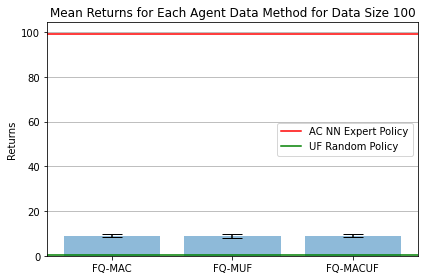

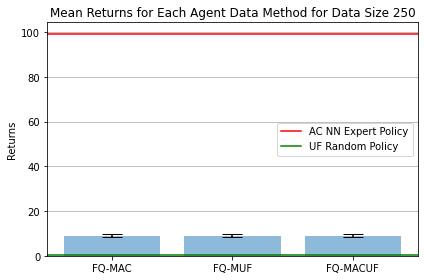

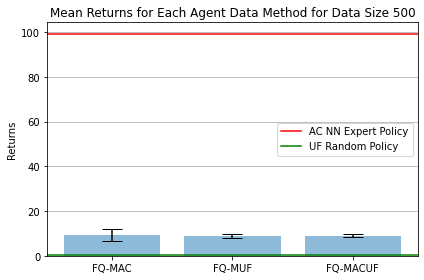

In [45]:
#calculate the average return of the expert ac nn and uf random policy
mean_rewards_ac_nn = np.mean(np.mean(rewards_ac_nn[:,:], axis=0))
mean_rewards_uf = np.mean(np.mean(rewards_uf[:,:], axis=0))

#caluclate the mean and standard deviation of the rewards for each agent data method for each data size
#data size 100
mean_rewards_fq_ac_mac_d1 = np.mean(rewards_fq_ac[0])
std_rewards_fq_ac_mac_d1 = np.std(rewards_fq_ac[0])
mean_rewards_fq_ac_muf_d1 = np.mean(rewards_fq_ac[1])
std_rewards_fq_ac_muf_d1 = np.std(rewards_fq_ac[1])
mean_rewards_fq_ac_macuf_d1 = np.mean(rewards_fq_ac[2])
std_rewards_fq_ac_macuf_d1 = np.std(rewards_fq_ac[2])
#data size 250
mean_rewards_fq_ac_mac_d2 = np.mean(rewards_fq_ac[3])
std_rewards_fq_ac_mac_d2 = np.std(rewards_fq_ac[3])
mean_rewards_fq_ac_muf_d2 = np.mean(rewards_fq_ac[4])
std_rewards_fq_ac_muf_d2 = np.std(rewards_fq_ac[4])
mean_rewards_fq_ac_macuf_d2 = np.mean(rewards_fq_ac[5])
std_rewards_fq_ac_macuf_d2 = np.std(rewards_fq_ac[5])
#data size 500
mean_rewards_fq_ac_mac_d3 = np.mean(rewards_fq_ac[6])
std_rewards_fq_ac_mac_d3 = np.std(rewards_fq_ac[6])
mean_rewards_fq_ac_muf_d3 = np.mean(rewards_fq_ac[7])
std_rewards_fq_ac_muf_d3 = np.std(rewards_fq_ac[7])
mean_rewards_fq_ac_macuf_d3 = np.mean(rewards_fq_ac[8])
std_rewards_fq_ac_macuf_d3 = np.std(rewards_fq_ac[8])


# for data size 100 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_ac_mac_d1, mean_rewards_fq_ac_muf_d1, mean_rewards_fq_ac_macuf_d1]
stds = [std_rewards_fq_ac_mac_d1, std_rewards_fq_ac_muf_d1, std_rewards_fq_ac_macuf_d1]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 100')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_ac_mac_d2, mean_rewards_fq_ac_muf_d2, mean_rewards_fq_ac_macuf_d2]
stds = [std_rewards_fq_ac_mac_d2, std_rewards_fq_ac_muf_d2, std_rewards_fq_ac_macuf_d2]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 250')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()





# for data size 250 plot in a bar chart the mean and standard deviation of the rewards for each agent data method
x_labels = ['FQ-MAC', 'FQ-MUF', 'FQ-MACUF']
means = [mean_rewards_fq_ac_mac_d3, mean_rewards_fq_ac_muf_d3, mean_rewards_fq_ac_macuf_d3]
stds = [std_rewards_fq_ac_mac_d3, std_rewards_fq_ac_muf_d3, std_rewards_fq_ac_macuf_d3]

fig, ax = plt.subplots()
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Returns')
ax.set_title('Mean Returns for Each Agent Data Method for Data Size 500')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_rewards_ac_nn, color='r', linestyle='-', label='AC NN Expert Policy')
plt.axhline(y=mean_rewards_uf, color='g', linestyle='-', label='UF Random Policy')


# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
#train using another learning rate
learning_rate = 0.0001

## Offline RL on CartPole v1 (with multi-layer perceptron) Offline Training

In [ ]:
#TODO Code similar to above
#Modify class A2C(nn.Module) using multiple layers for state (non-binned) actor/critic input and action/value output 

## (CartPole State Discretization Method) Sample CartPole environment velocities to calculate the bins discretization

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

num_episodes = 100
num_runs = 10
seeds = [0, 137, 2, 3, 4, 42, 6, 7, 8, 9]

cart_velocities = []
pole_velocities = []
for run in range(num_runs):
    print("Run {}".format(run))
    cart_evm = []
    pole_evm = []
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seeds[run])
        truncated = False
        terminated = False
        cart_ev = []
        pole_ev = []
        while not (truncated or terminated):
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            cart_ev.append(obs[1])
            pole_ev.append(obs[3])
            env.render()

        cart_evm.append(np.mean(cart_ev))
        pole_evm.append(np.mean(pole_ev))

    cart_velocities.append(cart_evm)
    pole_velocities.append(pole_evm)

cart_velocities = np.array(cart_velocities)
pole_velocities = np.array(pole_velocities)

print("Mean velocity: {:.2f}".format(np.mean(cart_velocities)))
print("Variance of velocity: {:.2f}".format(np.var(cart_velocities)))
print("Minimum velocity: {:.2f}".format(np.min(cart_velocities)))
print("Maximum velocity: {:.2f}".format(np.max(cart_velocities)))


In [ ]:
# plot the histogram of the cart velocities 
c_mean_velocity = np.mean(cart_velocities)
c_std_velocity = np.std(cart_velocities)

# plot the histogram of the pole velocities
p_mean_velocity = np.mean(pole_velocities)
p_std_velocity = np.std(pole_velocities)

# Define bins based on normal distribution of velocities for cart
bins_c = [-np.inf]
for i in range(1, 10):
    bin_start = (i - 5) * c_std_velocity/2
    bins_c.append(bin_start)
bins_c.append(np.inf)
# Create histogram of velocities
hist, bin_edges = np.histogram(cart_velocities, bins=bins_c)
print("Histogram of velocities:")
for i in range(len(hist)):
    print("[{:.2f}, {:.2f}): {}".format(bin_edges[i], bin_edges[i+1], hist[i]))

# Define bins based on normal distribution of velocities for pole
bins = [-np.inf]
for i in range(1, 10):
    bin_start = (i - 5) * p_std_velocity/2
    bins.append(bin_start)
bins.append(np.inf)
# Create histogram of velocities
hist, bin_edges = np.histogram(pole_velocities, bins=bins)
print("Histogram of velocities:")
for i in range(len(hist)):
    print("[{:.2f}, {:.2f}): {}".format(bin_edges[i], bin_edges[i+1], hist[i]))

print(bins_c)
print(bins)